max val at 1au is  2.463235269548971 W/m2/nm
checkpoint 1
PART 2


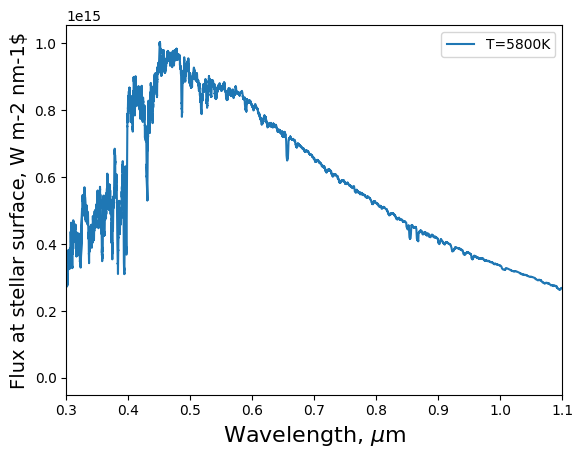

In [65]:
#load modules
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys

#Function to smooth the spectrum - smooth out the very small scale structure we dont care about. This doesn’t make the data smaller though                                                                          
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

#this routine makes the data smaller
def reduce_by_interpolation(spectrum, newsize=1000):
    '''                                                                                                         
    Reduces the resolution of the spectrum, so that the size is less than 1000 points, by interpolating          
    then resamplign the data.                                                                                   
    Args:                                                                                                       
        spectrum : the spectral singal, in the standard two-column format                                        
        newsize : the size to resample to (default 1000), if spectrum is smaller than this                       
            will return the original array                                                                      
    Returns:                                                                                                    
        A reduced spectrum.                                                                                     
    '''
    rows, cols = spectrum.shape
    if rows <= newsize:
        print("Warning: Spectral data already less than "+str(newsize)+' data points, no reduction performed')
        return spectrum
    else:
        l1 = np.min(spectrum[:,0])
        l2 = np.max(spectrum[:,0])
        xnew = np.linspace(l1, l2, newsize)
        ynew = np.interp(xnew, spectrum[:,0], spectrum[:,1])
        newspectrum = np.zeros((newsize, 2))
        newspectrum[:,0] = xnew
        newspectrum[:,1] = ynew
        return newspectrum
#Constants:                                                                                                     
#To convert angstroms to microns                                                                                
AngstromToMicron = 0.0001
AngstromTonm = 0.1

#PHOENIX: Wavelengths come in Angstroms                                                                         
wavelengths_data = fits.getdata("WAVE_PHOENIX-ACES-AGSS-COND-2011.fits")

#This is the flux array in erg s-1 cm-2 cm-1. 
#This is the file you would be reading in. Change to whatever spectrum name we end up using.                                                                    
Star1_data = fits.getdata("lte05800-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
maxVal1 = 0.0
maxVal2 = 0.0
Rsol = 6.96e8 #solar radius in cm
au = 1.5e11   #1au in cm 
for i in range(0, len(Star1_data)):
    if(Star1_data[i] > maxVal1):
        maxVal1 = Star1_data[i]
        maxIndex = i
print("max val at 1au is ", Star1_data[maxIndex]*Rsol**2/au**2/1.e10, "W/m2/nm")
#sys.exit()                                                                                                     



np.savetxt("raw_PHOENIX_3500K.txt", np.c_[wavelengths_data*AngstromTonm, Star1_data*Rsol**2/au**2/1.e10])
print("checkpoint 1")

#Do the smoothing                                                                                               
smoothed1 = movingaverage(Star1_data, 30000)

#reduce the number of points in the spectrum
reduced1=reduce_by_interpolation(np.c_[wavelengths_data,smoothed1], newsize=4000)

#save the smoothed, reduced, spectrum
np.savetxt("reduced4000_SmoothedSpectrum30000_PHOENIX_5800K.txt", np.c_[reduced1[:,0]*AngstromTonm, reduced1[:,1\
]*Rsol**2/au**2/1.e10])


print("PART 2")
#Save a less smoothed version too                                                                               
smoothed1 = movingaverage(Star1_data, 3000)


reduced1=reduce_by_interpolation(np.c_[wavelengths_data,smoothed1], newsize=4000)

np.savetxt("reduced4000_SmoothedSpectrum3000_PHOENIX_5800K.txt", np.c_[reduced1[:,0]*AngstromTonm, reduced1[:,1]\
*Rsol**2/au**2/1.e10])



#Plot the spectral models                                                                                       
plt.plot(wavelengths_data*AngstromToMicron, smoothed1, label="T=5800K")

plt.ylabel("Flux at stellar surface, W m-2 nm-1$", fontsize=14)
plt.xlim(0.3, 1.1)
plt.xlabel("Wavelength, $\mu$m", fontsize=16)
#plt.xscale("log")                                                                                              
#plt.yscale("log")                                                                                              
plt.legend()
plt.show()

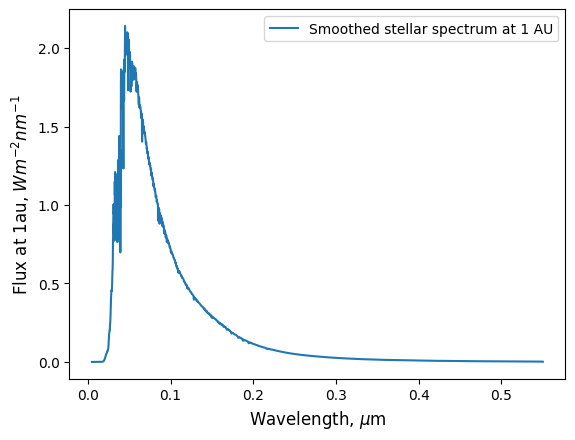

In [58]:
stellar_spectrum = np.loadtxt("reduced4000_SmoothedSpectrum3000_PHOENIX_5800K.txt" )

# Extract the wavelength and intensity columns
wavelengths = stellar_spectrum[:, 0]
intensity = stellar_spectrum[:, 1]

# Create a plot
plt.plot(wavelengths*AngstromToMicron, intensity, label='Smoothed stellar spectrum at 1 AU')
plt.xlabel("Wavelength, $\mu$m", fontsize=12)
plt.ylabel("Flux at 1au, $W m^{-2} nm^{-1}$", fontsize=12)
plt.legend()
plt.show()


In [53]:
#check number of data points
num_lines_trn = sum(1 for _ in open('psg_trn.txt'))
num_lines_stellar = sum(1 for _ in open('reduced4000_SmoothedSpectrum30000_PHOENIX_5800K.txt'))
print(num_lines_trn, num_lines_stellar)

715 4000


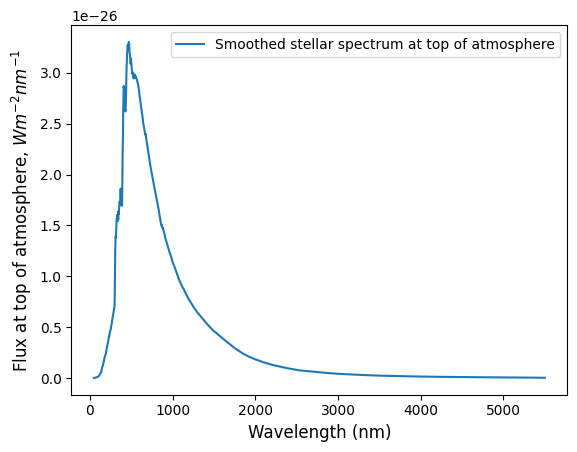

In [68]:
au_to_cm = 1.496e13  # convert au to cm

spectrum = np.loadtxt("reduced4000_SmoothedSpectrum30000_PHOENIX_5800K.txt")

# Extract wavelengths and fluxes
wavelengths = spectrum[:, 0]  # first column is wavelengths
flux_at_1_au = spectrum[:, 1]  # second column is flux at 1 au

distance_au = 0.1491 # distance from star to planet in au
orbital_distance_cm = distance_au * au_to_cm

# flux at the top of the atmosphere
flux_at_top_of_atmosphere = flux_at_1_au / (4 * np.pi * orbital_distance_cm**2)
np.savetxt("flux_at_top_of_atmosphere.txt", np.c_[wavelengths, flux_at_top_of_atmosphere])

plt.plot(wavelengths, flux_at_top_of_atmosphere, label='Smoothed stellar spectrum at top of atmosphere')
plt.ylabel("Flux at top of atmosphere, $W m^{-2} nm^{-1}$", fontsize=12)
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.legend()
plt.show()


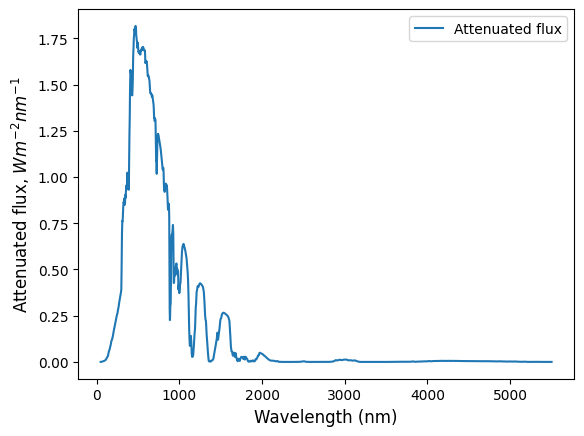

In [69]:
stellar_data = np.loadtxt("reduced4000_SmoothedSpectrum30000_PHOENIX_5800K.txt")
stellar_wavelengths = stellar_data[:, 0]  # wavelengths in nm
stellar_flux = stellar_data[:, 1]         # fluxes

# Transmittance spectrum
transmittance_data = np.loadtxt("psg_trn.txt", skiprows=6) #skip first 6 rows
transmittance_wavelengths = transmittance_data[:, 0] * 1000  # convert um to nm
transmittance_values = transmittance_data[:, 1]               # total transmittance

# Interpolate transmittance onto the stellar spectrum wavelengths
interpolated_transmittance = np.interp(stellar_wavelengths, transmittance_wavelengths, transmittance_values)

# Apply transmittance to the stellar spectrum
attenuated_flux = stellar_flux * interpolated_transmittance

np.savetxt("attenuated_spectrum.txt", np.c_[stellar_wavelengths, attenuated_flux])

plt.plot(stellar_wavelengths, attenuated_flux, label="Attenuated flux")
plt.ylabel("Attenuated flux, $W m^{-2} nm^{-1}$", fontsize=12)
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.legend()
plt.show()
